In [44]:
## Import_PY
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
## Import_TF
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import load_model

In [46]:
## 선박 DATAFRAME 생성 함수

def Ship_DATA():
  ## DB 연결
  conn = pymysql.connect(host= '127.0.0.1', user= 'test',
                      password='test1234', db='test_1', charset='utf8')

  cur = conn.cursor()
  cur.execute('select * from ais')
  A = cur.fetchall()
  cur.execute('select * from ship')
  B = cur.fetchall()
  
  ## DF
  df_1 = pd.DataFrame(A)
  df_1.columns = ['Date', 'Cog', 'Longitude', 'Latitude', 'Kn', 'MMSI']

  df_2 = pd.DataFrame(B)
  df_2.columns = ['MMSI', 'ShipName', 'Type']

  # 소수점 제한 : 파이썬에서 표기와 DB에서의 표기가 소수점 제한이 다름
  df_3 = pd.merge(df_1, df_2)
  df_3['Cog'] = round(df_3['Cog'], 5)
  df_3['Kn'] = round(df_3['Kn'], 2)
  df_3 = df_3[df_3['Kn'] != 0.0]

  # 기상데이터와 연결하기 위한 열 생성
  df_3['시간'] = df_3['Date'].dt.strftime('%Y-%m-%d %H:%M')
  
  return df_3

In [47]:
# 모듈 제작용도 기상데이터(과거) : 해운대 일대 해양데이터를 기반으로 함

def Weather_Past():
  # 해당 학습기간동안의 CSV_File읽어오기
  df_4 = pd.read_csv('기상.csv', encoding='cp949')

  # Data 전처리
  df_4 = df_4.drop(['No','파향16방위', '유향16방위', '수온(°C)', '관측소명', '유의파주기',
                    '파향', '기온(°C)', '기압(hPa)', '풍향16방위'], axis=1)

  df_4.columns = ['시간', '파고','유속', '유향', '풍속', '풍향']
  
  # null 존재 유무 판단
  df_4.isnull().sum()
  df_4 = df_4.dropna(axis=0)
  df_4 = df_4.reset_index()    # 인덱스 새로 설정
  df_4 = df_4.drop(['index'], axis=1)

  # 유속의 단위를 Kn으로 통일
  for i in range(len(df_4['유속'])):
    df_4['유속'][i] = '0' + df_4['유속'][i][:3]

  return df_4

In [48]:
## MODEL 제작 전처리/정규화 함수 - df_3 + df_4

def Normalize(df_3, df_4):
  # df_5 : 학습용 최종 DataFrame
  df_5 = pd.merge(df_3, df_4)
  df_5 = df_5.drop(['시간'], axis=1)

  # MinMaxScaler() : 정규화
  scaler = MinMaxScaler()
  scale_cols = ['Cog', 'Longitude', 'Latitude', 'Kn',
                '파고', '유속', '유향', '풍속', '풍향']

  # fit_transform() : train data에만 적용하며, 학습하고 평균과 분산에 맞춰서 변형
  scale_df = scaler.fit_transform(df_5[scale_cols])
  scale_df = pd.DataFrame(scale_df, columns=scale_cols) # 정규화된 새로운 DF생성
  

  quest_col = ['Cog', 'Longitude', 'Latitude', 'Kn',
               '파고', '유속', '유향', '풍속', '풍향']  # 예측을 위해 필요한 열명   
  
  ans_col_1 = ['Longitude', 'Latitude', 'Cog', 'Kn']  # 예측하고자 하는 열명

  feat_df = pd.DataFrame(scale_df, columns=quest_col) # 예측하기 위한 DataFrame
  label_df_1 = pd.DataFrame(scale_df, columns=ans_col_1)  # 예측결과값 DataFrame

  # 값을 numpy로 전환
  feat_np = feat_df.to_numpy()
  label_np = label_df_1.to_numpy()

  return feat_np, label_np

In [49]:
## Train data, Test data로 분류

def make_sequene_dataset(feature, label, window_size):
  # 입력데이터와 정답데이터를 저장할 빈 리스트
  feature_list=[]
  label_list=[]

  # feature - window_size : 들어온 데이터의 길이중 첫번째는 window-size로 사용되어 제외
  for i in range(len(feature) - window_size):
    # 슬라이싱 [[0~window_size에 해당하는 데이터까지], [1~window_size+1에 해당하는 데이터까지]]
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  # np.array형식으로 리턴하여 (batch_size, time step, input dims)로 반환
  return np.array(feature_list), np.array(label_list)

In [50]:
## MODEL 구축함수
def Model_create(x_train, y_train, x_test, y_test):
  ## model 구축
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, activation='tanh', input_shape = x_train[0].shape, return_sequences= True),
    tf.keras.layers.Dense(100, activation = 'linear'),
    tf.keras.layers.LSTM(128, activation='tanh'), 
    tf.keras.layers.Dense(4, activation='linear')
  ])

  ## compile & learning
  from keras.callbacks import EarlyStopping
  # mae : 오차 절댓값
  model.compile(loss='mse', optimizer = 'adam', metrics=['accuracy'])
  ea_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000,
                batch_size=16, callbacks=[ea_stop])

  ## 예측 및 평가
  pred = model.predict(x_test)
  metrics = model.evaluate(x_test, y_test, batch_size=16)
  print('##### Test Result #####')
  print('loss : ', str(metrics[0]))
  print('accuracy : ', str(metrics[1]))

  return pred, model


In [51]:
df_3 = Ship_DATA()

# 1. 선박 1종류 선택
df_3['ShipName'].unique()
df_3 = df_3[df_3['ShipName'] == 'NO.107 CHUNG RYONG']
df_3 = df_3.reset_index()
df_3 = df_3.drop(['index'], axis=1)
df_3.head()

,Date,Cog,Longitude,Latitude,Kn,MMSI,ShipName,Type,시간
0,2023-01-30 17:07:46,120.1,129.074755,35.101918,7.6,440107360,NO.107 CHUNG RYONG,52,2023-01-30 17:07
1,2023-01-30 17:07:49,120.2,129.074863,35.101866,7.8,440107360,NO.107 CHUNG RYONG,52,2023-01-30 17:07
2,2023-01-30 17:07:59,119.9,129.075240,35.101683,7.5,440107360,NO.107 CHUNG RYONG,52,2023-01-30 17:07
3,2023-01-30 17:08:20,115.6,129.076040,35.101352,7.6,440107360,NO.107 CHUNG RYONG,52,2023-01-30 17:08
4,2023-01-30 17:08:29,117.0,129.076399,35.101212,7.6,440107360,NO.107 CHUNG RYONG,52,2023-01-30 17:08


In [52]:
df_4 = Weather_Past()

C:\Users\user\AppData\Local\Temp\ipykernel_5196\1904076193.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['유속'][i] = '0' + df_4['유속'][i][:3]


In [53]:
a = Normalize(df_3, df_4)

In [54]:
## 학습데이터 X, Y 생성
window_size = 2
X, Y = make_sequene_dataset(a[0], a[1], window_size)

# train data, test data 분리
split = -50

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1856, 2, 9) (1856, 4)
(50, 2, 9) (50, 4)


Epoch 1/1000
116/116 [==============================] - 3s 9ms/step - loss: 0.0262 - accuracy: 0.8044 - val_loss: 0.0186 - val_accuracy: 0.8400
Epoch 2/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0057 - accuracy: 0.8874 - val_loss: 0.0183 - val_accuracy: 0.8400
Epoch 3/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0060 - accuracy: 0.8842 - val_loss: 0.0187 - val_accuracy: 0.8400
Epoch 4/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0051 - accuracy: 0.8998 - val_loss: 0.0170 - val_accuracy: 0.8400
Epoch 5/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0050 - accuracy: 0.8982 - val_loss: 0.0168 - val_accuracy: 0.8600
Epoch 6/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0050 - accuracy: 0.8852 - val_loss: 0.0163 - val_accuracy: 0.8800
Epoch 7/1000
116/116 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.8971 - val_loss: 0.0166 - val_accuracy:

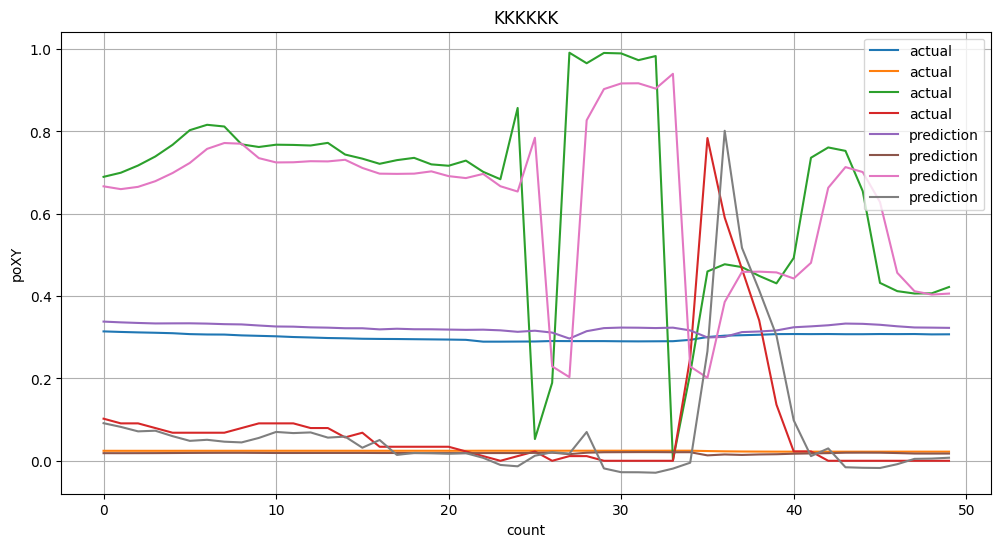

In [55]:
pred = Model_create(x_train, y_train, x_test, y_test)

plt.figure(figsize=(12, 6))
plt.title('KKKKKK')
plt.ylabel('poXY')
plt.xlabel('count')
plt.plot(y_test, label='actual')
plt.plot(pred[0], label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [56]:
pred[1].save('Last_LSTM_Model.h5')